# Хакатон Моторика

## Часть 2 Анализ данных и разрабоотка свертки 

Для улучшения качества работы наших протезов мы решаем задачу “распознавания жестов”.
В данном хакатоне мы предлагаем решить задачу классификации с известными заранее классами:

Описание данных
X_train.npy и X_test.npy имеют следующие размерности (наблюдения, датчики, время);
y_train.csv содержит следующие классы:
"0" - разгиб жеста "grab"    
"1" - разгиб жеста "ok"   
"2" - разгиб большого пальца    
"3" - разгиб указательного пальца    
"4" - разгиб жеста "пистолет"   
"5" - разгиб среднего пальца   
"6" - разгиб безымянного пальца   
"7" - разгиб мизинца   
"8" - сгиб мизинца    
"9" - сгиб безымянного пальца   
"10" - сгиб среднего пальца   
"11" - сгиб жеста "пистолет"    
"12" - сгиб указательного пальца   
"13" - сгиб большого пальца   
"14" - сгиб жеста "ok"   
"15" - сгиб жеста "grab"   

Задача: построение классификационной модели, которая по показаниям от датчиков будет определять жест, выполненный пользователем протеза во время записи данных, что отражено в значении целевой переменной.

Данные - это оптомиография, сырые значения оптической плотности (optical density) + шумы и дрейфы. Оптическая плотность может изменяться в зависимости от выполняемого жеста. Измеряется в значениях АЦП, это отчёты от 0 до 4096, в диапазоне от 0 до 3.3в. Частота измерения - 30 Гц. 

## Краткое содержание предыдущей части и планы на эту часть

На основе исходных данных без всяких преобразований сделано MVP и получен хороший результат. 
В этой части я решил посмотреть таки на данные.  Потом возникла идея - как сократить одну из осей исходных данных.  Результат получился чуточку хуже чем MVP (по kaggle).

## Изучение исходных данных

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [4]:
data = np.load('data/X_train.npy')
data.shape

(165, 40, 60)

In [5]:
y = pd.read_csv('data/y_train.csv', index_col=0)
y = y.Class


Id
0       5
1       8
2      11
3       9
4      14
       ..
160     4
161    10
162     3
163    15
164     2
Name: Class, Length: 165, dtype: int64

In [24]:
n_class = 16
n_samples = 10
n_sens = 40
t_frame = 60

str_data = np.zeros((n_class, n_samples, n_sens, t_frame))
q_samples = np.zeros((n_class))
gr_x = np.arange(t_frame)/30.   #Частота измерения 30 Гц

Структурирую данные.  Исходные данные 165 наблюдений за жестами разбираются в 16 классов по 10 наблюдений за жестами.

In [25]:
for i in range(165):
    g = y[i]  # Номер жеста
    if q_samples[g] < 10:
        q = int(q_samples[g])
        str_data[g][q][:][:] = data[i][:][:]
        q_samples[g] = q + 1

Посмотрим на графики сигналов с датчиков жестов одного типа.  После преобразования у нас получилось 16 классов жестов, 10 наблюдений в каждом и каждое наблюдение - таймфрейм сигналов 40 датчиков за 60 интервалов времени = 2 сек.  Поскольку частота наблюдений 30 Гц - общая длительность каждого тайм-фрейма - 2 сек. 

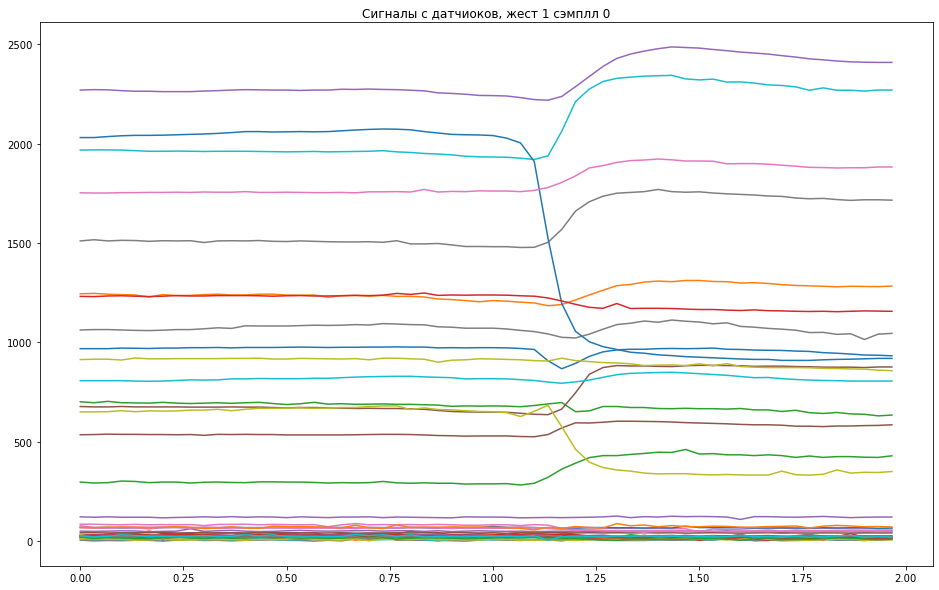

----------


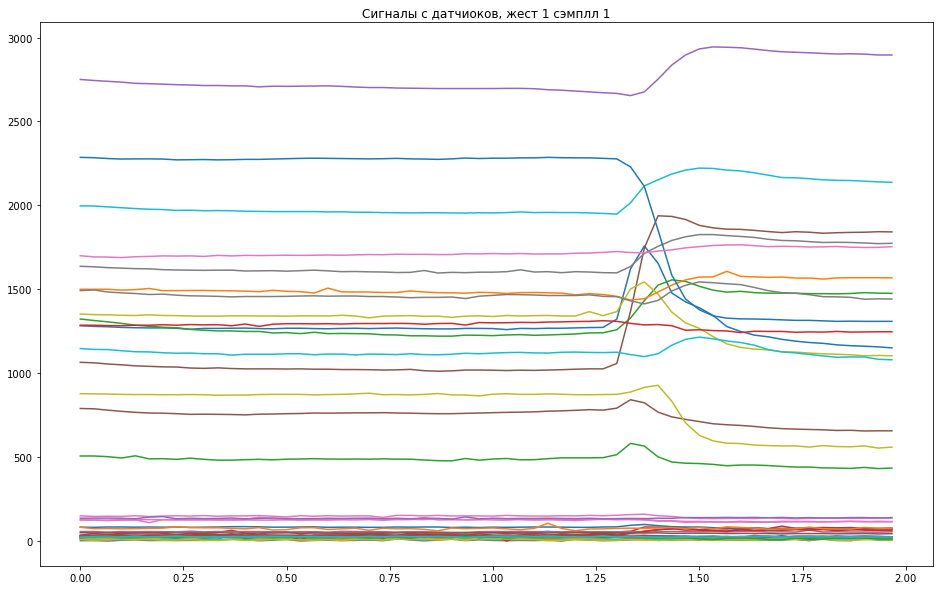

----------


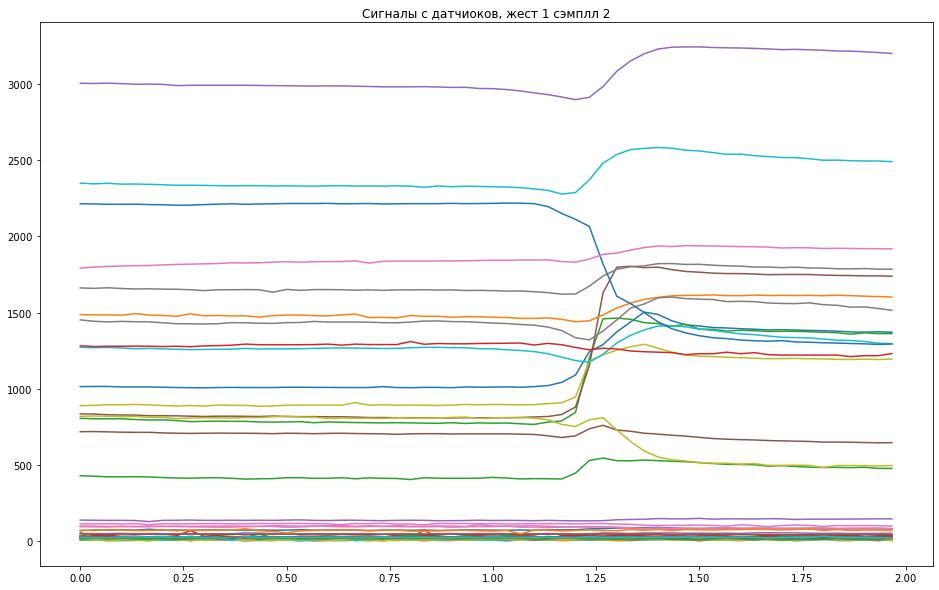

----------


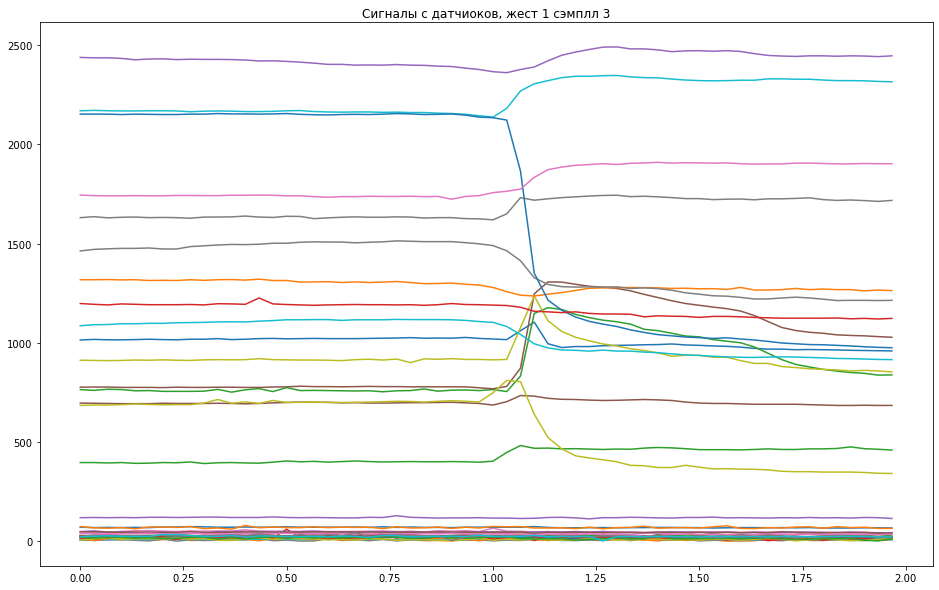

----------


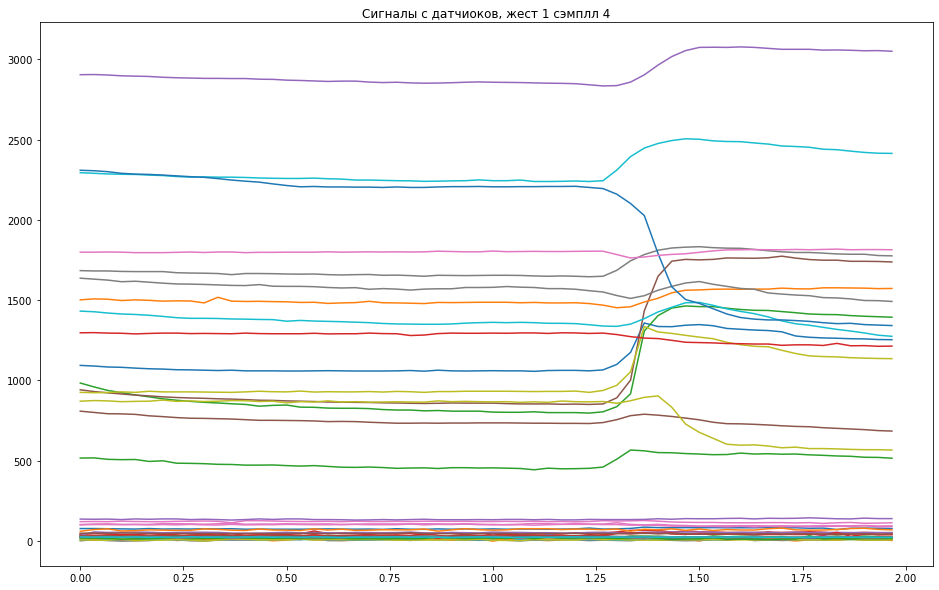

----------


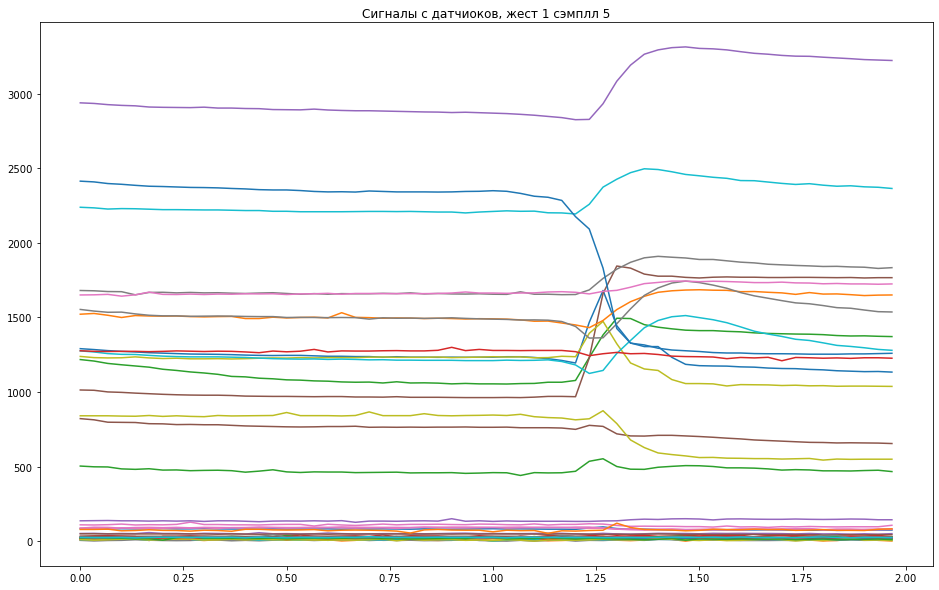

----------


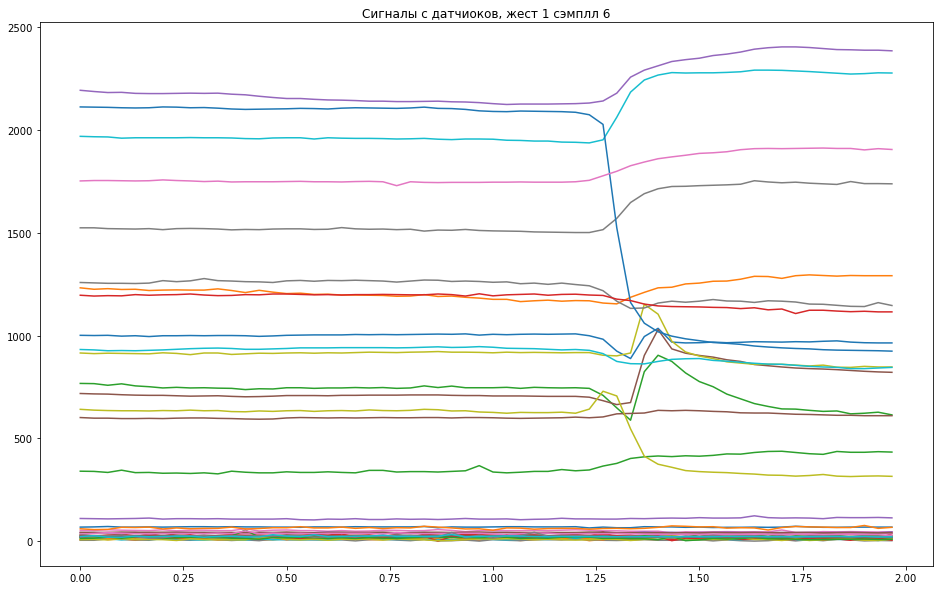

----------


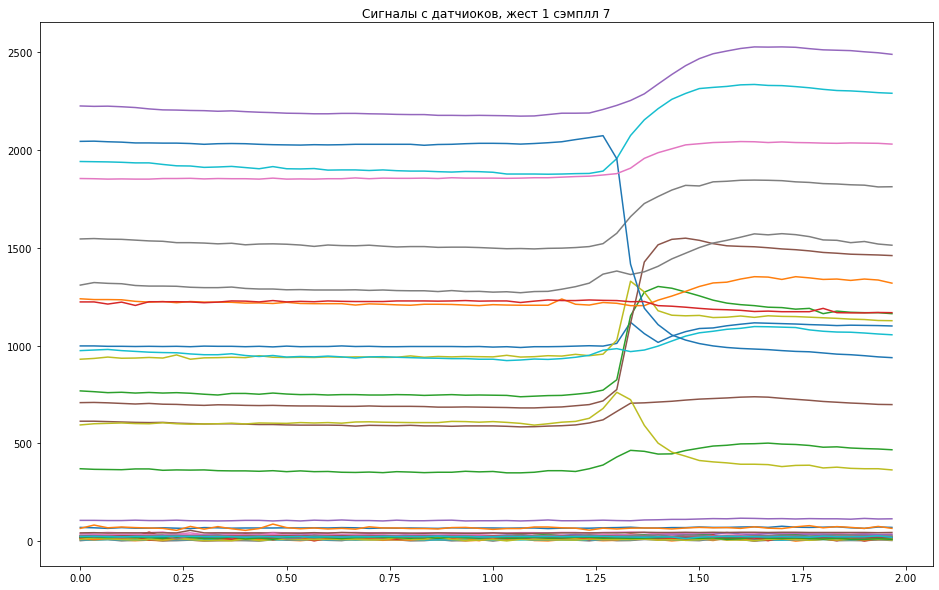

----------


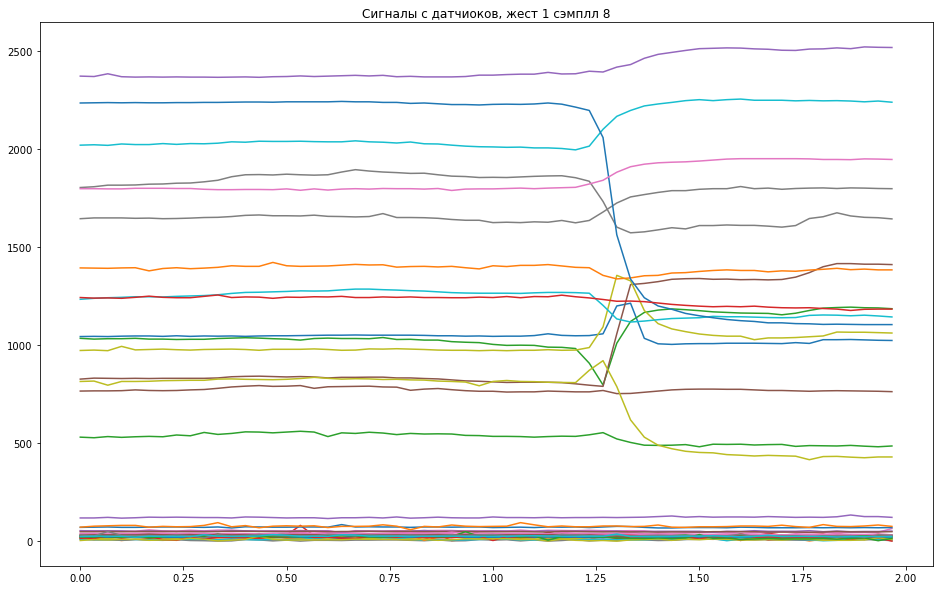

----------


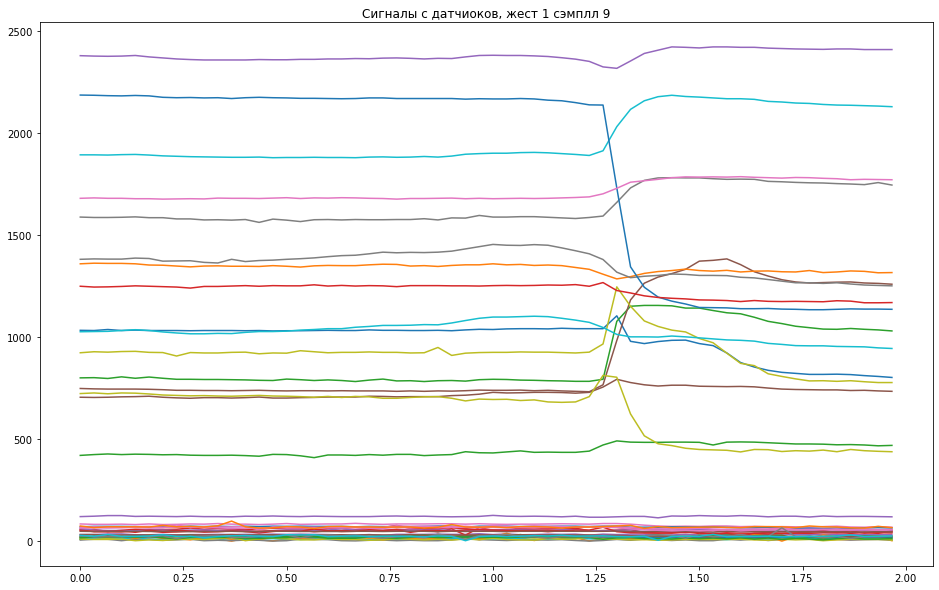

----------


In [26]:
gesture = 1
for sample in range(10):
    plt.figure(figsize=(16,10))
    plt.title('Сигналы с датчиоков, жест '+str(gesture)+' сэмплл '+str(sample))
    for i in range(40): 
        plt.plot(gr_x,str_data[gesture,sample,i,:])
    plt.show();
    print('----------')

Бросается в глаза, что часть сигналов представляют собой просто шум, случайные колебания и не имеют значания для предсказания данного жеста.  Другие сигналы содержат существенные изменения уровня и вероятно как раз и влияют на распознавание жеста. 
Необходимо как то попробовать разобрать и исключить мешающие каналы.  Также возможно, что удастся понизить размерность задачи и вместо фрейма времени использовать рассчитанную характеристику. 

Попробую измерить уровень шума в состоянии покоя как СКО сигнала в каналах нижней части графика. 

No handles with labels found to put in legend.


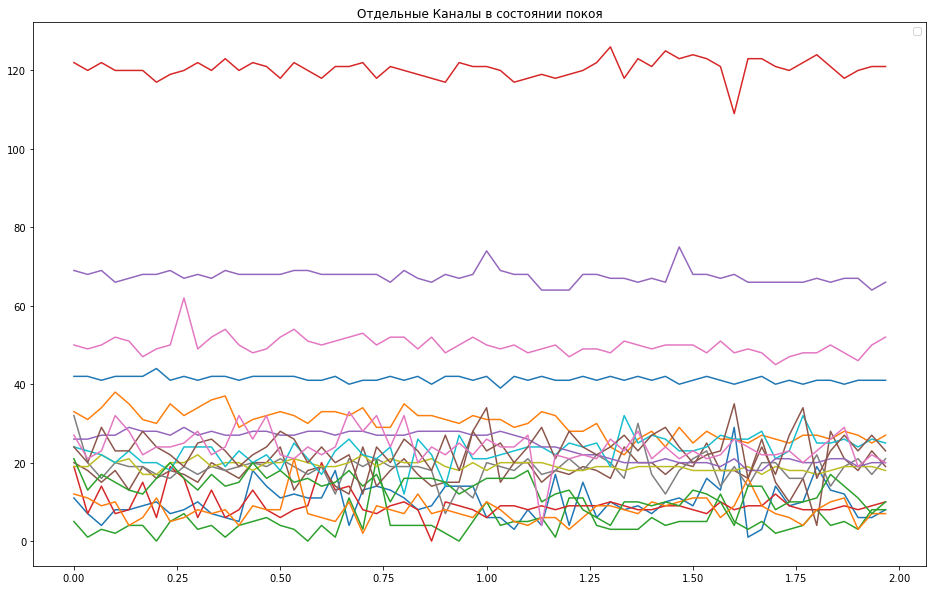

In [131]:
sensors = [ 1, 4, 7, 9, 10, 11, 14, 18, 20, 22,  25,  28,  32, 34, 35, 37, 39]


plt.figure(figsize=(16,10))
plt.title('Отдельные Каналы в состоянии покоя')
plt.legend(loc='best')
for i in sensors: 
    plt.plot(gr_x,str_data[1,0,i,:])
plt.show();

Думаю что этот набор сигналов точно не содержит полезных сигналов и может быть использован для определения уровня фонового шума. 

In [136]:
noise_std = list()
for i in sensors:
    noise_std.append(str_data[1,0,i,:].std())
print(np.mean(noise_std))

3.1844885105945644


Таким образом полагаю что СКО фонового уровня шума составляет 3.18 (мВ).  Эта характеристика шума может быть использована в дальнейшем, например для генерации значений сигналов в состоянии покоя.  

## Разработка подхода по скоращению оси времени в исходных данных


Первый шаг - попробовать продифференцировать входные сигналы - взять разность между текущим и предыдущим значениями сигнала. 

In [29]:
# Пусть 
cl = 1  #class
sa = 1  #sample
# diff_data = np.zeros((n_sens,t_frame-1))   #При дифференцировании первого порядка получается на одно значение меньше

diff_data = np.diff(str_data[cl,sa,:,:],axis=1)
diff_data.shape

(40, 59)

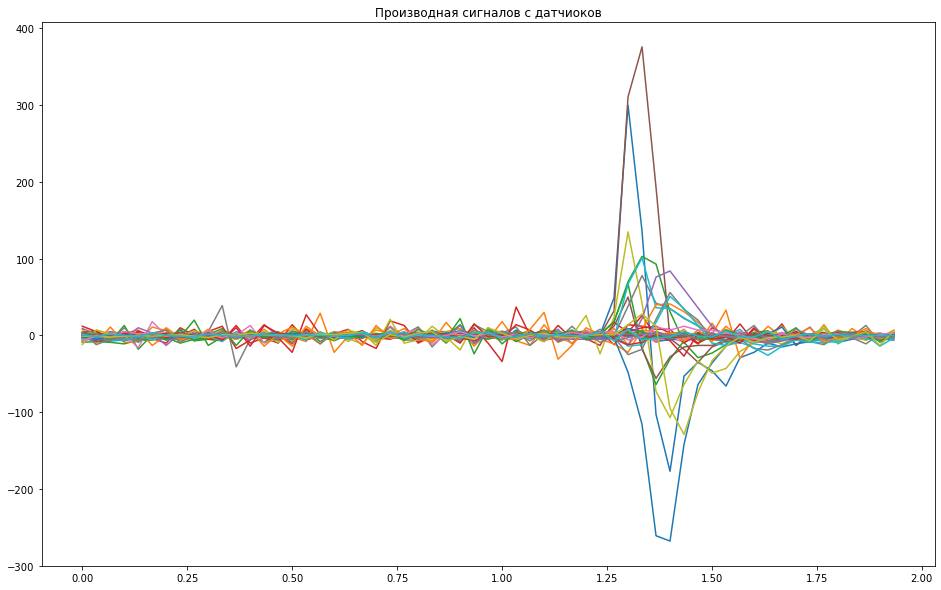

In [32]:
plt.figure(figsize=(16,10))
plt.title('Производная сигналов с датчиоков')   #, жест '+str(gesture)+' сэмплл '+str(sample))
for i in range(40): 
    plt.plot(gr_x[0:59],diff_data[i,:])
plt.show();

Пробую посмотреть на максимальное абсолютное значение амплитуды производной.  

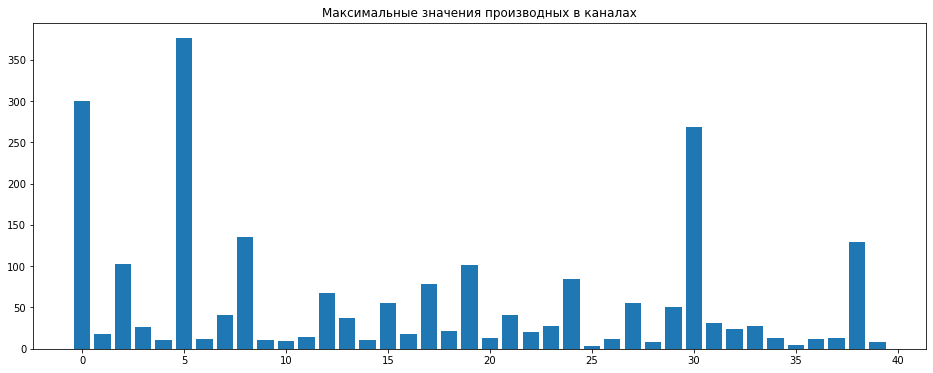

In [68]:
max_diff = np.zeros((n_sens))
for i in range(n_sens): 
    max_diff[i] = np.abs(diff_data[i,:]).max()
plt.figure(figsize=(16,6))
plt.title('Максимальные значения производных в каналах')  
plt.bar(np.arange(n_sens),max_diff)
plt.show();

Максимальное значение АЦП - 3300 мВ.  Если задаться точностью в 1%FS, то измерения с максимальным значением производной ниже 33 подлежат исключению. 
Глядя на график и вспоминая общую метрологию можно предположить порог отсечения на уровне 50 (1.5% FS).

В данном случая я пробую сделать параметрическую фильтрацию по уровню первой производной - если она меньше порога, то убираю значение производной в ноль. 

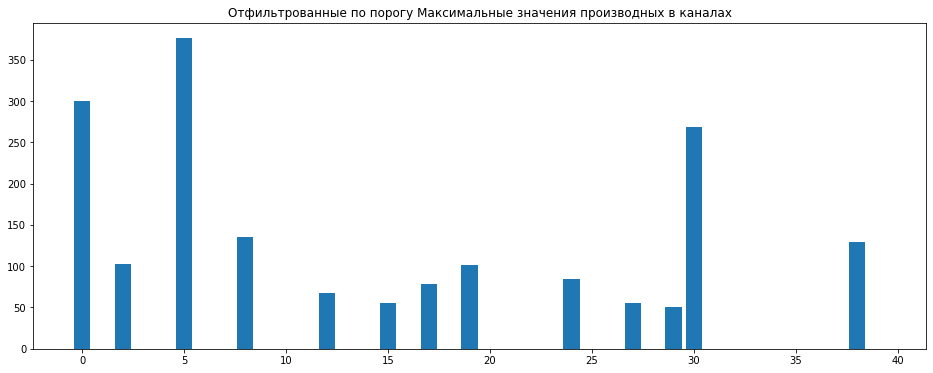

In [38]:
threshold = 50
filtered_max_diff = np.where(max_diff<threshold,0,max_diff)

plt.figure(figsize=(16,6))
plt.title('Отфильтрованные по порогу Максимальные значения производных в каналах')  
plt.bar(np.arange(n_sens),filtered_max_diff)
plt.show();

Попробую отфильтровать шум по амплитуде с сохранением знака производной. 

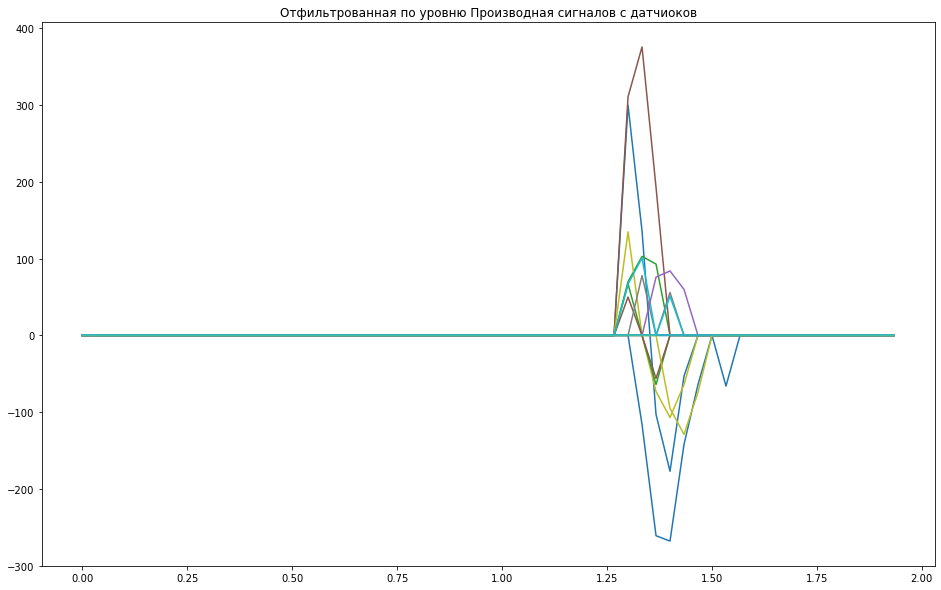

In [69]:
fltr_diff_data = np.zeros_like(diff_data)
for sens in range(n_sens):
    fltr_diff_data[sens] = np.where(np.abs(diff_data[sens])<threshold, 0, diff_data[sens])
plt.figure(figsize=(16,10))
plt.title('Отфильтрованная по уровню Производная сигналов с датчиоков')   #, жест '+str(gesture)+' сэмплл '+str(sample))
for i in range(40): 
    plt.plot(gr_x[0:59], fltr_diff_data[i,:])
plt.show();

В данном месте необходимо сделать замечание.  Текущая задача не предусматривает обнаружения момента времени жеста (хотя бы в относитьельных отсчетах).  Если далее в соревновании или на практике будет поставлена:
- задача распознавания момента жеста на записанных данных (тайм-фреймах), то момент жеста (в отсчетах с начала тайм-фрейма) можно опреденить как аргумент максимума наибольшего по амплитуде изменения сигнала оптической плотности датчика, или np.argmax(np.abs(diff_data)).
- задача распознавания момента жеста на потоке данных, то момент жеста с некоторой задержкой момжно определять как наличие максимума первой производной наибольшего по амплитуде изменения сигнала при условии, что это момент максимума отстоит от текущего наблюдения на необходимую задержку.  Подобрать задержку можно на практике исходя из минимизации задержки и минимизации ложных срабатываний. 



Теперь попробую сделать интегрирование отфильтрованного сигнала на участке фрейма (без начального значения).  по сути речь идет о накоплении кумулятивной суммы изменений сигнала за время длительности таймфрейма. 


In [46]:
cum_diff = np.zeros(n_sens)
for s in range(n_sens):
    cum_diff[s] = fltr_diff_data[s,:].sum()

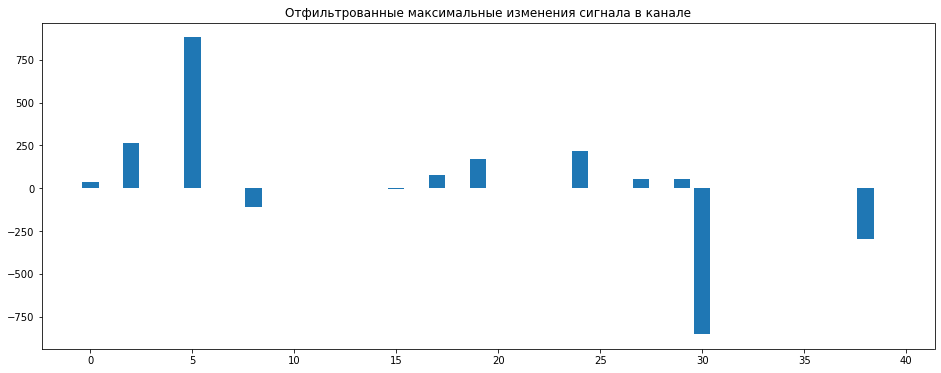

In [48]:
plt.figure(figsize=(16,6))
plt.title('Отфильтрованные максимальные изменения сигнала в канале')  
plt.bar(np.arange(n_sens),cum_diff)
plt.show();

Получается довольно интересно. Надо сделать функцию фильтрации и потом попробовать обработать все наборы и посмотреть на результат.  Необходимо как то назвать результат применения обработки, сворачивающей время. Путь это будет **Шаг** (Step) вверх или вниз.

In [64]:
# Фильтрация первой производной по амлитуде (больше порога) и последующее интегрирование
# data - оригинальные измерения с датчиков
# thr - пороговый уровень фильтрации первой производной
def cum_signed_diff(data, thr, n_sens): 
    # t_frame = data.shape[0]
    cdiff = np.zeros(n_sens)
    for s in range(n_sens):
        ddata = np.diff(data[s,:])
        fddata = np.where(np.abs(ddata)<thr,0,ddata)
        cdiff[s] = fddata.sum()
    return cdiff

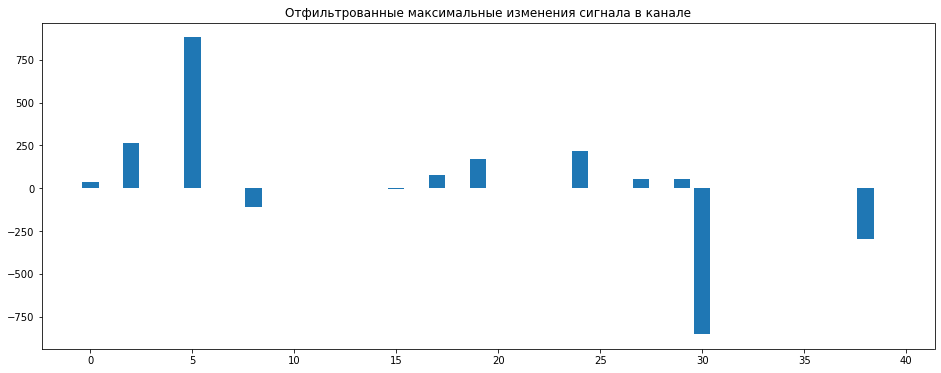

In [67]:
cdiff = cum_signed_diff( str_data[cl,sa,:,:], threshold, n_sens)
plt.figure(figsize=(16,6))
plt.title('Отфильтрованные максимальные изменения сигнала в канале')  
plt.bar(np.arange(n_sens),cdiff)
plt.show();

Я предполагаю, что классификатору нужно выучить такие соотношения.  Для начала попробую просто проанализировать исходную базу по жестам. 

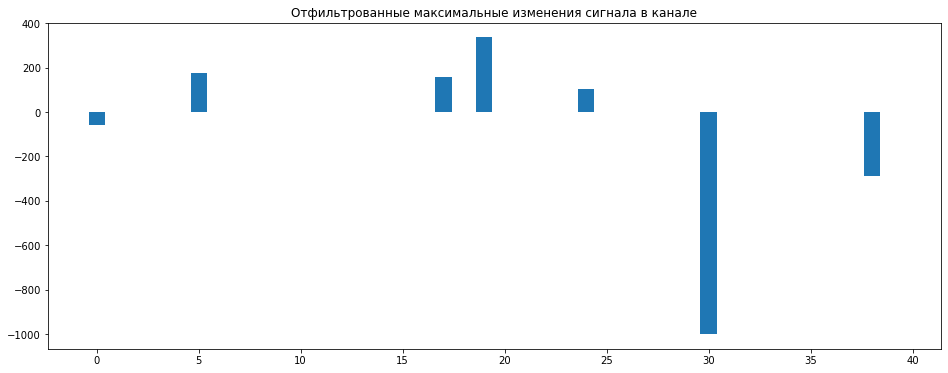

---------------


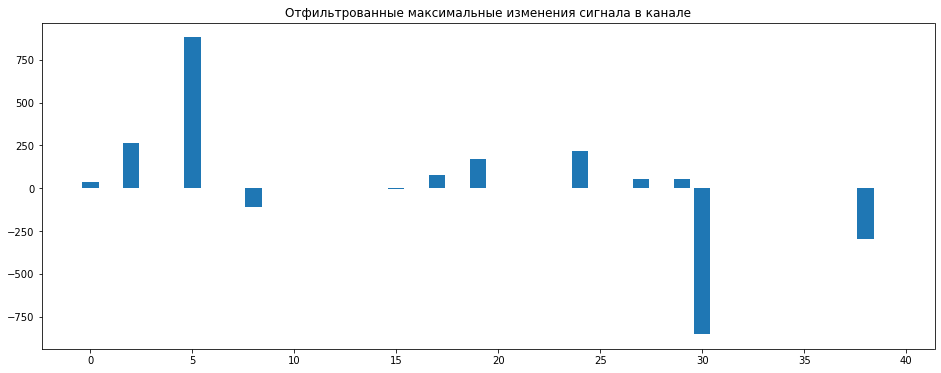

---------------


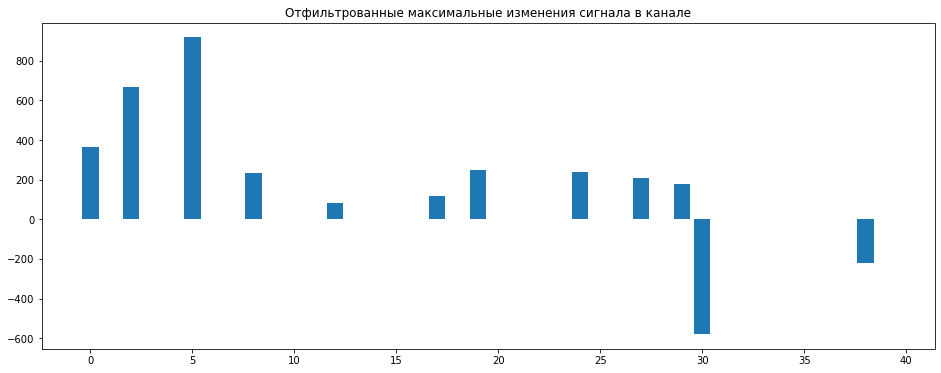

---------------


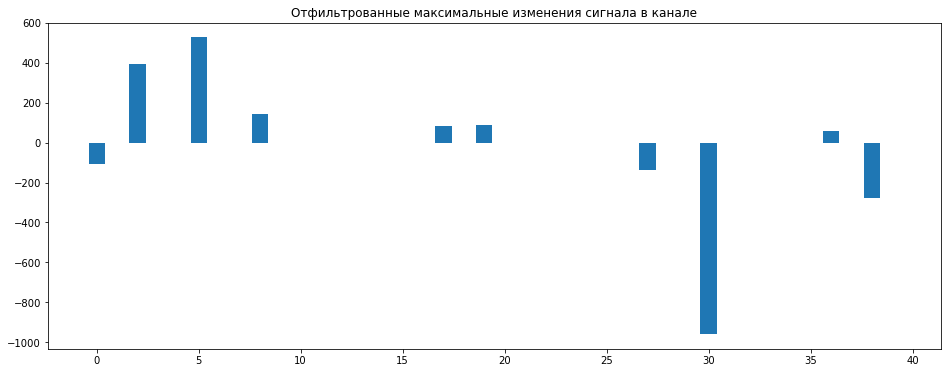

---------------


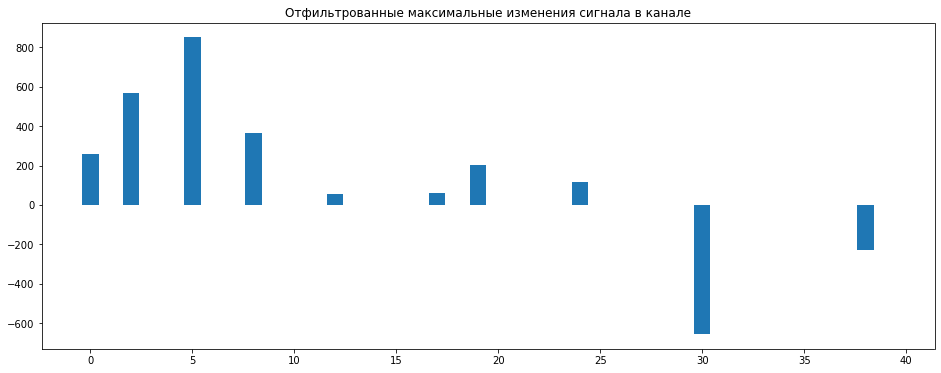

---------------


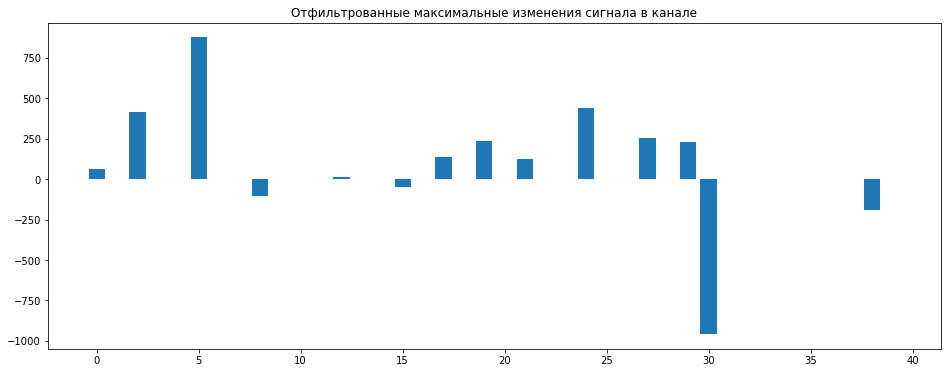

---------------


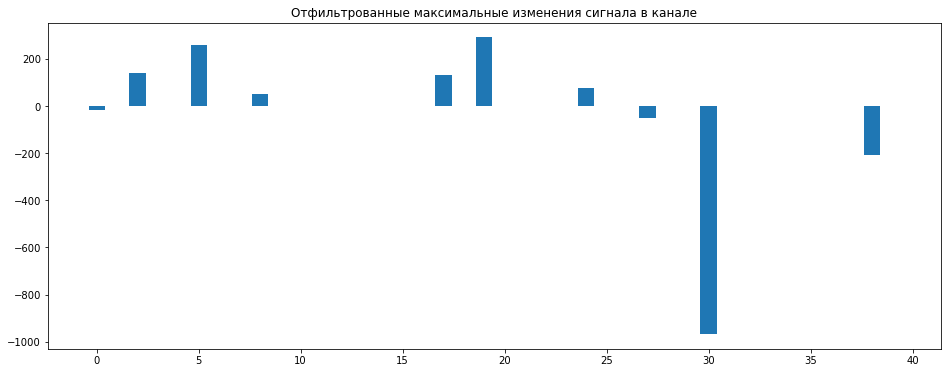

---------------


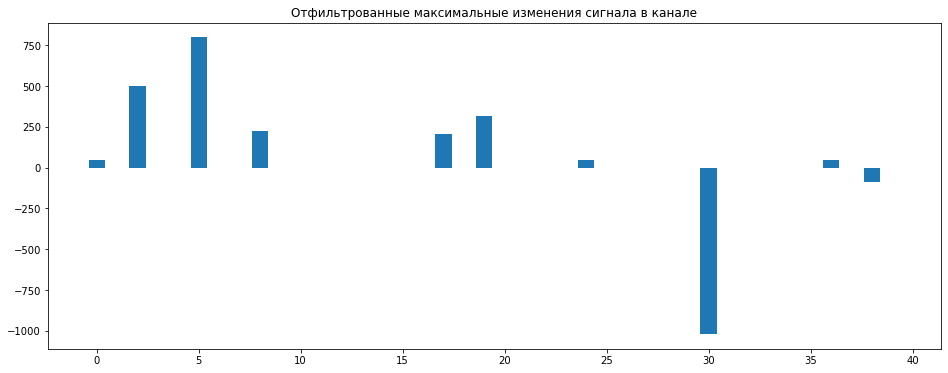

---------------


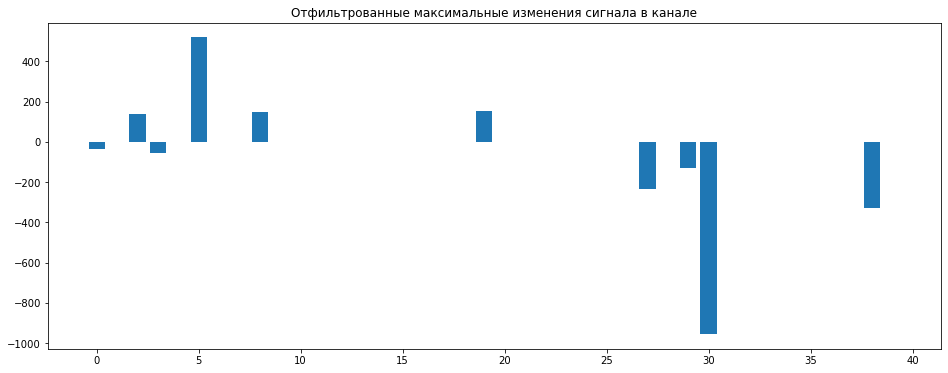

---------------


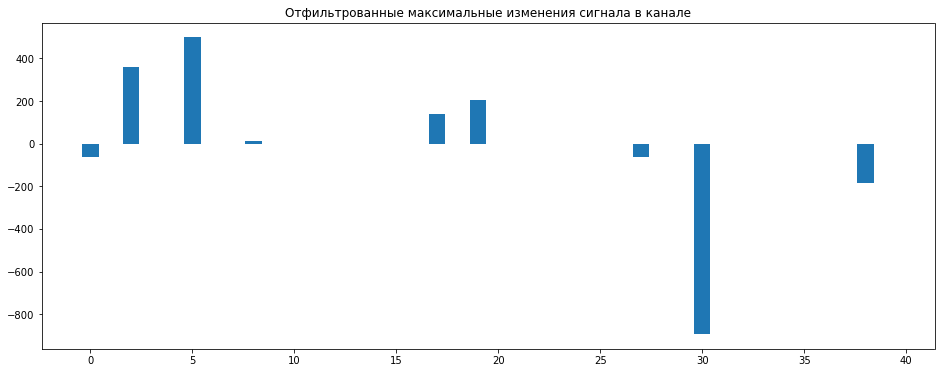

---------------


In [70]:
gesture = 1
for sample in range(10):
    cdiff = cum_signed_diff( str_data[cl,sample,:,:], threshold, n_sens)
    plt.figure(figsize=(16,6))
    plt.title('Отфильтрованные максимальные изменения сигнала в канале')  
    plt.bar(np.arange(n_sens),cdiff)
    plt.show();
    print('---------------')

## Разботка и оценка модели на основе данных о Шагах

Результат интересный - пробую преобразовать таким образом массив исходных неразобранных данных.

In [74]:
# Функция преобразования исходных данных, не разобранных по наблюдениям в новую форму
def parse_data(data, thr):
    n_samples = data.shape[0]
    n_sens = data.shape[1]
    p_data = np.zeros((n_samples,n_sens))  # Я предполагаю сократить размерность задачи на одно измерение. 
    for i in range(n_samples):
        p_data[i] = cum_signed_diff(data[i,:,:], thr, n_sens)
    return p_data

In [75]:
parsed_data =  parse_data( data, 50)
parsed_data.shape

(165, 40)

In [77]:
# Функция добавления шума в свернутые результаты:
# На вход подается вектор со значениями величины шага и такой же измененный вектор возвращается
# level - максимальны уровень изменений 
# prob - вероятность изменения величины шага
def add_noise_to_steps(orig,level=0.015,prob=0.5):
    size = orig.shape[0]
    # rv = np.random.rand(size)
    mult = 1 + (np.random.rand(size)-0.5) * level
    return np.where(np.random.rand(size)<=prob,orig * mult, orig)


Снова генерирую набор данных для обучения

In [84]:
X_ext = parsed_data
y_ext = y
for i in range(2000):
    loc = round(np.random.rand()*164)
    y_ext = pd.concat([y_ext,pd.Series(np.array([y[loc]]), name='Class') ], axis=0, ignore_index=True)
    x_add = add_noise_to_steps(parsed_data[loc,:]).reshape(1,-1)
    X_ext = np.concatenate((X_ext,x_add),axis=0)

print(X_ext.shape, y_ext.shape)

(2165, 40) (2165,)


Разделяю данные на обучение и валидацию.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_ext, y_ext, test_size = 0.2)
X_test.shape

(433, 40)

Пробую логистическую мультиклассовую классификацию. Гиперпараметры предоставил Степан Кутькин. 

In [88]:
LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42, max_iter=5000)
LR_clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test_review_tfidf)
y_pred = LR_clf.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  1.0


/Users/genn/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Пробую собрать файл для scoreboard

In [89]:
X_score = parse_data( np.load('data/X_test.npy'), 50)
X_score.shape

(166, 40)

In [90]:
y_score = pd.Series(data=LR_clf.predict(X_score),index=np.arange(166)+165,name='Class')
y_score.to_csv('220908_01.csv', index_label='Id')

Kaggle Score 0.93975

Результат чуточку хуже.  Кроме подбора гиперпараметров модели можно попробовать подобрать другие гиперпараметры:
- уровень шумодава (например 10 и 30)
- вероятность и уровень изменений исходных данных (например вероятность поднять до 0.8  и уровень изменений до 0.05 )

## Эксперименты по подбору уровня шумодава

Сначала я собрал все шаги в одну функцию. 

In [95]:
def parse_n_try(filename, data, threshold, prob=0.5, level=0.015):
    pr_data =  parse_data( data, threshold)
    print('parsed data shape:', pr_data.shape) 
    X_ext = pr_data
    y_ext = y
    for i in range(2000):
        loc = round(np.random.rand()*164)
        y_ext = pd.concat([y_ext,pd.Series(np.array([y[loc]]), name='Class') ], axis=0, ignore_index=True)
        x_add = add_noise_to_steps(pr_data[loc,:], level, prob).reshape(1,-1)
        X_ext = np.concatenate((X_ext,x_add),axis=0)
    print('Extended X:' , X_ext.shape, 'y:', y_ext.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X_ext, y_ext, test_size = 0.2)
    print('X_test shape', X_test.shape)

    LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42, max_iter=5000)
    LR_clf.fit(X_train, y_train)

    #y_pred = clf.predict(X_test_review_tfidf)
    y_pred = LR_clf.predict(X_test)
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))

    LR_clf.fit(X_ext, y_ext)
    
    X_score = parse_data( np.load('data/X_test.npy'), threshold)
    print('Score X shape', X_score.shape) 

    y_score = pd.Series(data=LR_clf.predict(X_score),index=np.arange(166)+165,name='Class')
    y_score.to_csv(filename, index_label='Id')
    

А теперь исполняю эту функцию с тестовыми параметрами. 

In [96]:
parse_n_try('220908_02.csv', data, 10, 0.5, 0.015)

parsed data shape: (165, 40)
Extended X: (2165, 40) y: (2165,)
X_test shape (433, 40)
Test Accuracy:  1.0
Score X shape (166, 40)


Kaggle Score 0.97590 

In [99]:
parse_n_try('220908_03.csv', data, 30, 0.5, 0.015)

parsed data shape: (165, 40)
Extended X: (2165, 40) y: (2165,)
X_test shape (433, 40)
Test Accuracy:  1.0
Score X shape (166, 40)


Kaggle Score 0.96385

In [101]:
parse_n_try('220908_04.csv', data, 10, 0.5, 0.05)

parsed data shape: (165, 40)
Extended X: (2165, 40) y: (2165,)
X_test shape (433, 40)
Test Accuracy:  1.0
Score X shape (166, 40)


Kaggle Score 0.97590

In [102]:
parse_n_try('220908_05.csv', data, 5, 0.5, 0.05)

parsed data shape: (165, 40)
Extended X: (2165, 40) y: (2165,)
X_test shape (433, 40)
Test Accuracy:  1.0
Score X shape (166, 40)


Kaggle Score: 0.97590

## Эксперименты по подбору гиперпараметров

In [140]:
def parse_n_try_2(filename, data, threshold, solver, C=100, prob=0.5, level=0.015):
    pr_data =  parse_data( data, threshold)
    print('parsed data shape:', pr_data.shape) 
    X_ext = pr_data
    y_ext = y
    for i in range(2000):
        loc = round(np.random.rand()*164)
        y_ext = pd.concat([y_ext,pd.Series(np.array([y[loc]]), name='Class') ], axis=0, ignore_index=True)
        x_add = add_noise_to_steps(pr_data[loc,:], level, prob).reshape(1,-1)
        X_ext = np.concatenate((X_ext,x_add),axis=0)
    print('Extended X:' , X_ext.shape, 'y:', y_ext.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X_ext, y_ext, test_size = 0.2)
    print('X_test shape', X_test.shape)

    LR_clf = LogisticRegression(multi_class='multinomial', solver=solver, C=C, random_state=42, max_iter=5000, n_jobs=-1)
    LR_clf.fit(X_train, y_train)

    #y_pred = clf.predict(X_test_review_tfidf)
    y_pred = LR_clf.predict(X_test)
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))

    LR_clf.fit(X_ext, y_ext)
    
    X_score = parse_data( np.load('data/X_test.npy'), threshold)
    print('Score X shape', X_score.shape) 

    y_score = pd.Series(data=LR_clf.predict(X_score),index=np.arange(166)+165,name='Class')
    y_score.to_csv(filename, index_label='Id')
    

In [141]:
parse_n_try_2('220910_01.csv', data, 10, 'newton-cg', 100, 0.5, 0.05)

parsed data shape: (165, 40)
Extended X: (2165, 40) y: (2165,)
X_test shape (433, 40)
Test Accuracy:  1.0
Score X shape (166, 40)


Kaggle Score 0.97590

In [143]:
parse_n_try_2('220910_02.csv', data, 10, 'lbfgs', 10, 0.5, 0.05)

parsed data shape: (165, 40)
Extended X: (2165, 40) y: (2165,)
X_test shape (433, 40)
Test Accuracy:  1.0
Score X shape (166, 40)


Резюме:  Маленькая модель имеет хорошие перспективы для встраивания в контроллер. Однако ее качество может быть улучшено. 